# Simulate GRBs with correlations

In [1]:
%env NUMEXPR_MAX_THREADS=16
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env DISPLAY=:0.0

env: NUMEXPR_MAX_THREADS=16
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: DISPLAY=:0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler
from zusammen.synthetic_populations.aux_samplers import TDecaySampler, DurationSampler, LumSampler, EpeakObsSampler
%matplotlib notebook
import cosmogrb

/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/popsynth/distribution.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar
/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/astromodels/functions/function.py:140: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  function_definition = my_yaml.load(dct['__doc__'])
/Users/fran/.virtualenvs/grb/lib/python3.8/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of xc to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)


Configuration read from /Users/fran/.threeML/threeML_config.yml


## Simulate population

In [25]:
pop_gen = popsynth.populations.SFRPopulation(r0=1./10, rise=1., decay=4.0,
                                             peak=1.5, r_max=7.0)

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

log_ep = LogNormalAuxSampler(name="log_ep", observed=False)
log_ep.mu=300
log_ep.tau=0.4

alpha = TruncatedNormalAuxSampler(name="alpha", observed=False)
alpha.lower=-1.5
alpha.upper=0.0
alpha.mu=-1
alpha.tau=0.25

ep_tau = TruncatedNormalAuxSampler(name="ep_tau", observed=False)
ep_tau.lower=-2
ep_tau.upper=-1
ep_tau.mu=-1.5
ep_tau.tau=0.25

log_nrest = LogNormalAuxSampler(name="log_nrest", observed=False)
log_nrest.mu = 1e52
log_nrest.tau = 0.1

gamma = TruncatedNormalAuxSampler(name="gamma", observed=False)
gamma.mu = 1.5
gamma.tau = 0.5
gamma.lower = 1.0
gamma.upper = 2.0

duration = DurationSampler()
obs_lum = LumSampler()
log_ep_obs = EpeakObsSampler()

duration.set_secondary_sampler(t90)
obs_lum.set_secondary_sampler(log_ep)
obs_lum.set_secondary_sampler(log_nrest)
obs_lum.set_secondary_sampler(gamma)
log_ep_obs.set_secondary_sampler(log_ep)

pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(obs_lum)
pop_gen.add_observed_quantity(log_ep_obs)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(ep_tau)

pop_gen._seed = 1234094

registering auxilary sampler: duration
registering derived luminosity sampler: obs_lum
registering auxilary sampler: log_ep_obs
registering auxilary sampler: alpha
registering auxilary sampler: ep_tau


In [26]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2, flux_sigma=0.0)
population.writeto("data/grb_pop.h5")

The volume integral is 3.811119



Expecting 2 total objects
Sampling: obs_lum
obs_lum is sampling its secondary quantities
Sampling: log_ep
Sampling: log_nrest
Sampling: gamma
Getting luminosity from derived sampler
Sampling: duration
duration is sampling its secondary quantities
Sampling: log_t90
Sampling: log_ep_obs
log_ep_obs is sampling its secondary quantities
Sampling: alpha
Sampling: ep_tau
Applying soft boundary



No Selection! Added back all objects
NO HIDDEN OBJECTS
Deteced 2 objects or to a distance of 1.32


## Simulate detection

In [27]:
from corr_cpl.corr_cpl_universe import GBM_CORR_CPL_Universe
from cosmogrb.universe.survey import Survey

In [28]:
universe = GBM_CORR_CPL_Universe('data/grb_pop.h5', save_path="data")

universe.go(client=None)

universe.save('data/grb_pop_survey.h5')

In [29]:
survey = Survey.from_file('data/grb_pop_survey.h5')
survey.info()

,0
n_grbs,2
is_processed,False


## Plot detected grbs

<IPython.core.display.Javascript object>


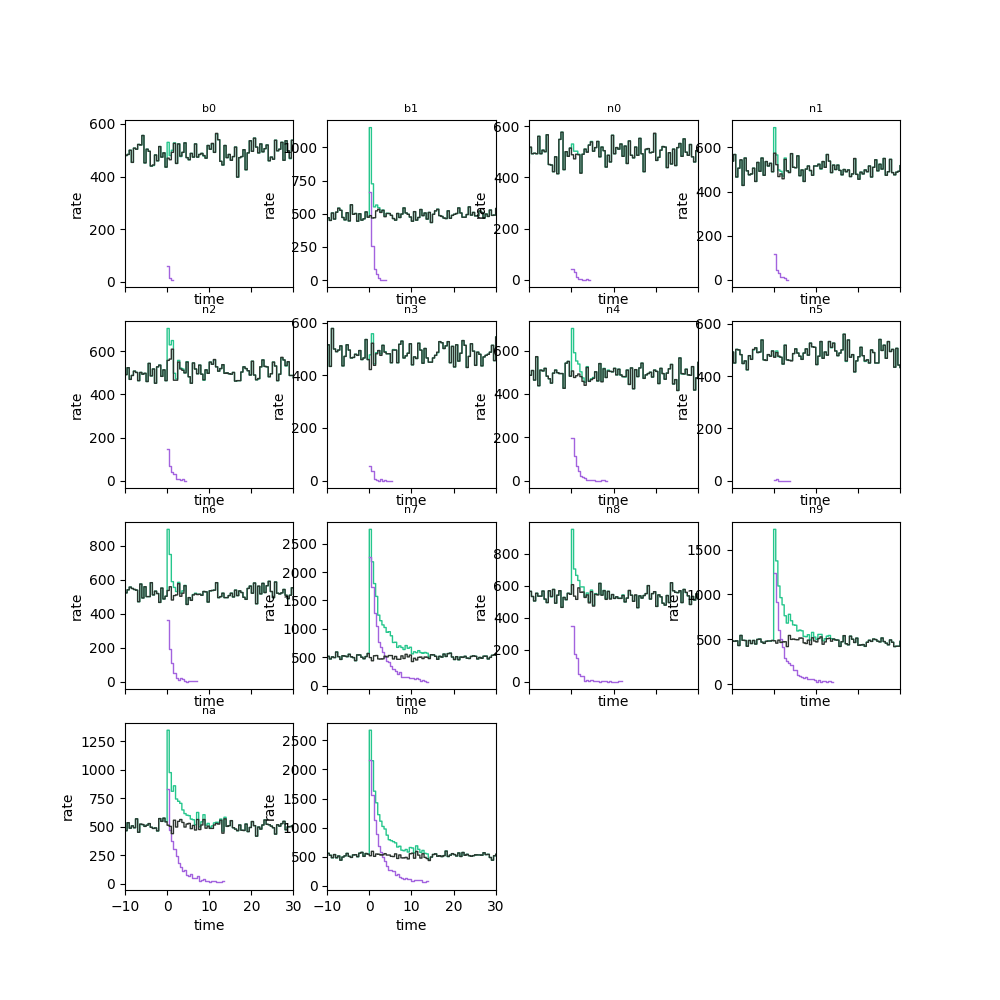

In [31]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey['SynthGRB_0'].grb.items():
    ax = axes[row][col]

    lightcurve =v['lightcurve']

    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)

    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)
axes[3,3].set_visible(False)

## Test reading in truths

In [67]:
from popsynth.distributions.cosmological_distribution import luminosity_distance

In [68]:
grbs = [survey[name].grb for name in survey]

In [69]:
gammas = [grb._source_params["gamma"] for grb in grbs]
Nrests = [grb._source_params["Nrest"] for grb in grbs]
alphas = [grb._source_params["alpha"] for grb in grbs]
ep_starts = [grb._source_params["ep_start"] for grb in grbs]
redshifts = [grb.z for grb in grbs]
dls = [luminosity_distance(z) for z in redshifts]
deltas = [np.log10(Nrest / (4*np.pi * dl**2)) for Nrest, dl in zip(Nrests, dls)]

In [75]:
deltas

[-6.707051452658284,
 -5.6783082465058685,
 -5.962758659809449,
 -6.172029899559857,
 -5.34902446113049]